In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

path = os.path.join("../data/speed_data_data.csv")
data = pd.read_csv(path)
data = data.iloc[:, 5:12]
data = data.dropna().reset_index(drop=True)
data.head()

,dec,attr,sinc,intel,fun,amb,shar
0,1,6.0,9.0,7.0,7.0,6.0,5.0
1,1,7.0,8.0,7.0,8.0,5.0,6.0
2,1,5.0,8.0,9.0,8.0,5.0,7.0
3,1,7.0,6.0,8.0,7.0,6.0,8.0
4,1,5.0,6.0,7.0,7.0,6.0,6.0


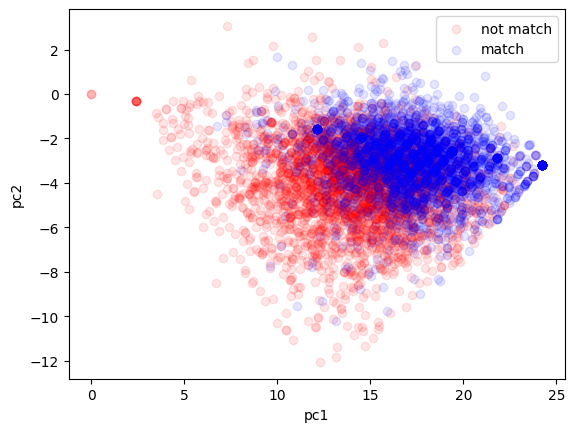

In [2]:
# PCA
feat = data.iloc[:, 1:]
feat_np = np.array(feat)
cov = np.array(feat.cov())
eig_value, eig_vector = np.linalg.eig(cov)
pc = feat_np @ eig_vector

# plots
labels_int = [0, 1]
labels = ["not match", "match"]
colors = {0: 'red', 1: 'blue'}
for i in range(2):
    indices = np.where(data['dec'] == labels_int[i])
    plt.scatter(pc[indices, 0], pc[indices, 1], c=colors[i], label=labels[i], alpha=0.1)
plt.xlabel("pc1")
plt.ylabel("pc2")
plt.legend()
plt.show()

/SSD_DISK/users/panzijie/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


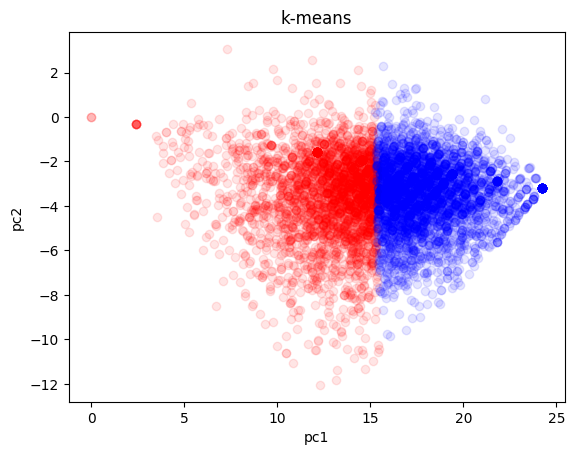

In [3]:
# k-means
from sklearn.cluster import KMeans

np.random.seed(999)
kmeans = KMeans(n_clusters=2)
kmeans.fit(feat_np)
labels_pred_kmeans = kmeans.predict(feat_np)

for i in range(2):
    indices = np.where(labels_pred_kmeans == 1-i)
    plt.scatter(pc[indices, 0], pc[indices, 1], c=colors[i], label=labels[i], alpha=0.1)
plt.xlabel("pc1")
plt.ylabel("pc2")
plt.title("k-means")
plt.show()


In [4]:
# EM
def safe_normalize(x, dim=0):
    logx = np.log(x)
    d = logx.max(dim)
    x_normalized = np.exp(logx - d) / (np.sum(np.exp(logx - d), dim))
    return x_normalized

def dnorm(x, u, sigma2):
    n = np.shape(x)[1]
    expOn = np.exp((-0.5 * (x - u) @ sigma2 * (x - u)).sum(1))
    #divBy = np.sqrt(pow(np.linalg.det(sigma2), 0.5))
    divBy = np.sqrt(pow(2 * np.pi, n)) * pow(np.linalg.det(sigma2), 0.5)
    return expOn / divBy


np.random.seed(999)
N, D = feat_np.shape
K = 2
r = np.array([np.random.dirichlet(np.ones(K)) for _ in range(N)]).T
r.sum(1) / N

# main loop
T = 100
mus = np.zeros([T, K, D])
ll = np.zeros(T)
for i in range(T):
    pi = r.sum(1) / N
    mu = r @ feat_np / r.sum(1)[..., None]
    mus[i] = mu
    sigma2 = np.zeros([K, D, D])
    for n in range(N):
        for k in range(K):
            x = (feat_np[n, :] - mu[k, :])[:, None]
            sigma2[k] += r[k, n] * (x @ x.T)
    sigma2 = sigma2 / r.sum(1)[..., None, None]

    r_raw = np.zeros([K, N])
    for k in range(K):
        rk = dnorm(feat_np, mu[k], sigma2[k])
        r_raw[k] = rk

    # r = safe_normalize(r_raw)
    r = r_raw / (r_raw.sum(0) + 1e-10)


In [5]:
# for i in range(2):
#     indices = np.where(data['dec'] == labels_int[i])
#     plt.scatter(pc[indices, 0], pc[indices, 1], c=colors[i], label=labels[i], alpha=0.01)
# plt.xlabel("pc1")
# plt.ylabel("pc2")
# plt.legend()
# 
# mu_pc = mus @ eig_vector
# plt.title('means trajectory')
# plt.plot(mu_pc[:, 0, 0], mu_pc[:, 0, 1], c='red', linewidth=1)
# plt.scatter(mu_pc[-1, 0, 0], mu_pc[-1, 0, 1], c='red')
# plt.plot(mu_pc[:, 1, 0], mu_pc[:, 1, 1], c='blue', linewidth=1)
# plt.scatter(mu_pc[-1, 1, 0], mu_pc[-1, 1, 1], c='blue')
# plt.show()

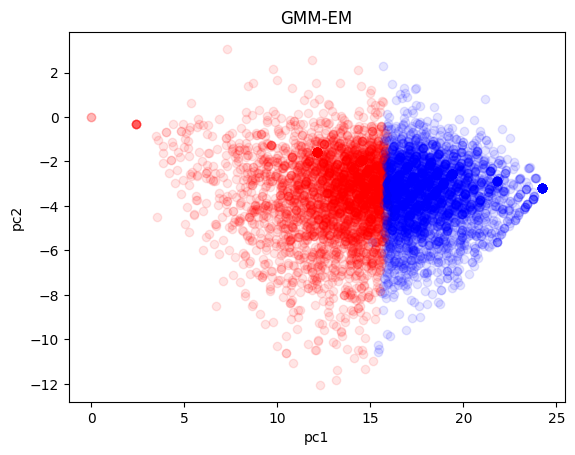

In [6]:
labels_pred_EM = r.argmax(0)
for i in range(2):
    indices = np.where(labels_pred_EM == 1-i)
    plt.scatter(pc[indices, 0], pc[indices, 1], c=colors[i], label=labels[i], alpha=0.1)
plt.xlabel("pc1")
plt.ylabel("pc2")
plt.title("GMM-EM")
plt.show()

In [7]:
# Variational Inference
from scipy.special import digamma

def updateXbar(r, X):
    Nk = r.sum(0)
    xbar = np.zeros([K, D])
    for n in range(N):
        for k in range(K):
            xbar[k, :] += r[n, k] * X[n, :]

    for k in range(K):
        xbar[k, :] = xbar[k, :] / Nk[k]

    return xbar


def updateS(r, X, xbar):
    Nk = r.sum(0)
    S = np.zeros([K, D, D])
    for n in range(N):
        for k in range(K):
            x = np.reshape(X[n, :] - xbar[k, :], (D, 1))
            S[k] += r[n, k] * (x @ x.T)

    for k in range(K):
        S[k] = S[k] / Nk[k]

    return S


def updateL(L0, xbar, S, beta0, Nk, m0):
    Linv = np.zeros([K, D, D])
    L = np.zeros([K, D, D])
    for k in range(K):
        x = np.reshape(xbar[k, :] - m0, (D, 1))
        Linv[k] = np.linalg.inv(L0) + Nk[k] * S[k] + (beta0 * Nk[k] / (beta0 + Nk[k])) * (x @ x.T)

    for k in range(K):
        L[k] = np.linalg.inv(Linv[k])
    return L


def updateM(beta0, betak, m0, Nk, xbar):
    m = np.zeros([K, D])
    for k in range(K):
        m[k, :] = (beta0 * m0 + Nk[k] * xbar[k, :]) / betak[k]
    return m


def Elogpi(alpha0, Nk):
    alphak = alpha0 + Nk
    log_pi_tilde = digamma(alphak) - digamma(alphak.sum())
    return log_pi_tilde


def ElogdetLambda(L, vk):
    log_Lambda_tilde = np.zeros(K)
    for k in range(K):
        log_Lambda_tilde[k] = np.sum([digamma((vk[k] + 1 - j) / 2.) for j in range(D)]) + D * np.log(2) + np.log(
            np.linalg.det(L[k]))
    return log_Lambda_tilde


def ExLx(X, betak, m, L, xbar, vk):
    xLx = np.zeros([N, K])
    for n in range(N):
        for k in range(K):
            x = np.reshape((X[n, :] - m[k, :]), (D, 1))
            xLx[n, k] = D / betak[k] + vk[k] * (x.T @ L[k] @ x)

    return xLx


def updateR(log_pi_tilde, log_Lambda_tilde, xLx):
    r = np.zeros([N, K])
    for k in range(K):
        r[:, k] = log_pi_tilde[k] + 0.5 * log_Lambda_tilde[k] - 0.5 * D * np.log(2 * np.pi) - 0.5 * xLx[:, k]

    r -= np.reshape(r.max(1), (N, 1))
    r = np.exp(r) / np.reshape(np.exp(r).sum(1), (N, 1))
    return r


K = 2
alpha0 = 0.1
beta0 = 1e-20
v0 = D + 1.
m0 = np.zeros(D)
L0 = np.eye(D)
r = np.array([np.random.dirichlet(np.ones(K)) for _ in range(N)])

T = 100
X = feat_np
ckpt_step = T // 4
for i in range(T):
    Nk = r.sum(axis=0)
    xbar = updateXbar(r, X)
    S = updateS(r, X, xbar)

    betak = beta0 + Nk
    m = updateM(beta0, betak, m0, Nk, xbar)
    L = updateL(L0, xbar, S, beta0, Nk, m0)
    vk = v0 + Nk + 1.

    log_pi_tilde = Elogpi(alpha0, Nk)
    log_Lambda_tilde = ElogdetLambda(L, vk)
    xLx = ExLx(X, betak, m, L, xbar, vk)
    r = updateR(log_pi_tilde, log_Lambda_tilde, xLx)

    # if i % ckpt_step == 0:
    #     labels_pred_VI = r.argmax(1)
    #     for j in range(2):
    #         indices = np.where(labels_pred_VI == j)
    #         plt.scatter(pc[indices, 0], pc[indices, 1], c=colors[j], label=labels[j], alpha=0.1)
    #     plt.xlabel("pc1")
    #     plt.ylabel("pc2")
    #     plt.title(f"Variational Inference at iteration {i}")
    #     plt.show()


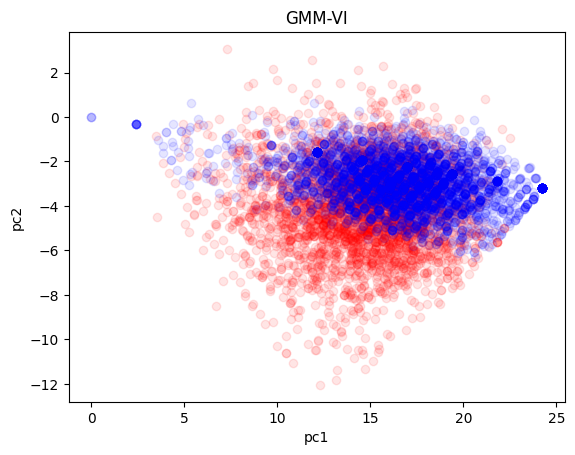

In [8]:
labels_pred_VI = r.argmax(1)
for i in range(2):
    indices = np.where(labels_pred_VI == i)
    plt.scatter(pc[indices, 0], pc[indices, 1], c=colors[i], label=labels[i], alpha=0.1)
plt.xlabel("pc1")
plt.ylabel("pc2")
plt.title("GMM-VI")
plt.show()

In [9]:
# Gibbs Sampling
from numpy.linalg import pinv
from scipy import stats


def draw_s_n(x_n, mu, Lmd, pi):
    eta_n = []
    for k in range(len(mu)):
        eta_nk = np.exp(
            -0.5 * (x_n - mu[k]) @ Lmd[k] @ (x_n - mu[k]).T
            + 0.5 * np.linalg.slogdet(Lmd[k])[1]
            + np.log(pi[k])
        )
        eta_n += [eta_nk]

    eta_n = np.array(eta_n) / sum(eta_n)

    return np.random.multinomial(1, pvals=eta_n)


def draw_Lmd_k_mu_k(X, S_k, m, beta, nu, W_inv):
    X_k = X[S_k == 1]

    sum_s_k = S_k.sum()
    beta_hat = sum_s_k + beta
    m_hat_k = (X_k.sum(axis=0) + beta * m) / beta_hat
    nu_hat = sum_s_k + nu
    sum_xx_n = sum([np.outer(X_k[n], X_k[n]) for n in range(len(X_k))])

    W_hat_k_inv = (
            sum_xx_n + beta * np.outer(m, m) - beta_hat * np.outer(m_hat_k, m_hat_k) + W_inv
    )

    Lmd_k = stats.wishart(nu_hat, pinv(W_hat_k_inv)).rvs()
    mu_k = stats.multivariate_normal(m_hat_k, pinv(beta_hat * Lmd_k)).rvs()

    return Lmd_k, mu_k


def draw_pi(S, alpha):
    alpha_hat = np.sum(S.T, axis=1) + alpha
    return stats.dirichlet.rvs(alpha_hat)[0]


X = feat_np
K = 2
N, D = X.shape
eps = 1.0e-2

smpl_hist = {}
smpl_hist["pi"] = [[1 / K for _ in range(K)]]
mu0 = X.mean(axis=0)
smpl_hist["mu"] = [[mu0.copy() + np.random.multivariate_normal(np.zeros(D), eps * np.eye(D)) for _ in range(K)]]
Lmd0 = np.corrcoef(X.T)
smpl_hist["Lmd"] = [[Lmd0 for _ in range(K)]]
S = [np.random.multinomial(1, pvals=smpl_hist["pi"][-1]) for _ in range(len(X))]
smpl_hist["S"] = [np.array(S).reshape(len(X), -1)]

ss = smpl_hist

# Hyperparameters
alpha = np.ones(K)
beta = 1.0
nu = D
W_inv = np.eye(D)

In [10]:
# main loop
T = 100
for i in range(T):

    # Draw S
    S = []
    for n in range(N):
        S += [draw_s_n(X[n], ss["mu"][-1], ss["Lmd"][-1], ss["pi"][-1])]
    ss["S"] += [np.array(S).reshape(N, K)]

    # Draw Lmd, mu
    Lmd = []
    mu = []
    for k in range(K):
        Lmd_k, mu_k = draw_Lmd_k_mu_k(
            X,
            ss["S"][-1][:, k],  # S_k
            ss["mu"][-1][k],  # m = mu_k
            beta,
            nu,
            W_inv,
        )
        Lmd += [Lmd_k]
        mu += [mu_k]

    ss["Lmd"] += [Lmd]
    ss["mu"] += [mu]

    # Draw pi
    pi = draw_pi(ss["S"][-1], alpha)
    ss["pi"] += [pi]


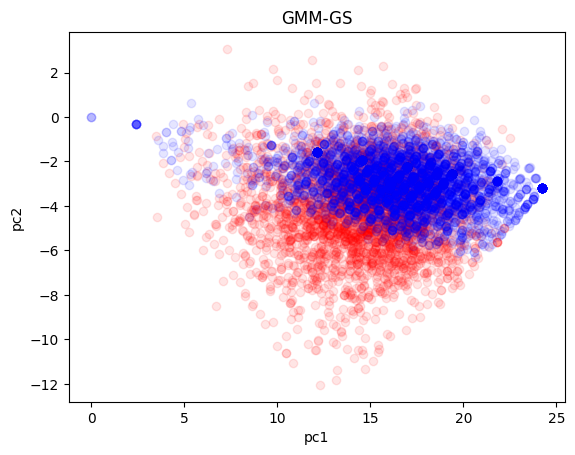

In [11]:
_S = sum(ss["S"]) / len(ss["S"])
labels_pred = []
for _s_n in _S:
    labels_pred += [_s_n.argsort()[-1]]
labels_pred_GS = np.array(labels_pred)
for i in range(2):
    indices = np.where(labels_pred_GS == i)
    plt.scatter(pc[indices, 0], pc[indices, 1], c=colors[i], label=labels[i], alpha=0.1)
plt.xlabel("pc1")
plt.ylabel("pc2")
plt.title("GMM-GS")
plt.show()

In [12]:
# Rand index
# from scipy.special import comb
# from itertools import combinations
# from tqdm import tqdm
# 
# 
# def rand_index(labels_gt, labels_pred):
#     pairs = list(combinations(range(len(labels_gt)), 2))
# 
#     def is_equal(x):
#         return (x[0] == x[1])
# 
#     a = 0
#     b = 0
#     for i in tqdm(range(len(pairs))):
#         if (is_equal((labels_gt[pairs[i][0]], labels_gt[pairs[i][1]])) == is_equal(
#                 (labels_pred[pairs[i][0]], labels_pred[pairs[i][1]]))
#                 and is_equal((labels_pred[pairs[i][0]], labels_pred[pairs[i][1]])) == True):
#             a += 1
#         if (is_equal((labels_gt[pairs[i][0]], labels_gt[pairs[i][1]])) == is_equal(
#                 (labels_pred[pairs[i][0]], labels_pred[pairs[i][1]]))
#                 and is_equal((labels_pred[pairs[i][0]], labels_pred[pairs[i][1]])) == False):
#             b += 1
#     denom = comb(len(labels_gt), 2)
#     ri = (a + b) / denom
#     return ri
# 
# (rand_index(data['dec'], labels_pred_kmeans),
#  rand_index(data['dec'], labels_pred_EM),
#  rand_index(data['dec'], labels_pred_VI),
#  rand_index(data['dec'], labels_pred_GS))